# Replication - Forest Figure

Here we provide a notebook to replicate the forest figure fro the UKB analysis.

The notebook replicates the results in:
- /ukb/output/forest_plot.eps

The main script can be found at: 
- /ukb/scripts/05_forest_plot.py



In [3]:
# Modules
# =======================================================================================================================

import os
import sys
import glob
import subprocess
import tqdm
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

np.random.seed(87)

In [27]:
# ICD10 Codes
# =======================================================================================================================

actionable_codes = ["I20 (angina pectoris)", "I21 (acute myocardial infarction)", "I22 (subsequent myocardial infarction)", "I23 (certain current complications following acute myocardial infarction)", "I24 (other acute ischaemic heart diseases)", "I25 (chronic ischaemic heart disease)", "I60 (subarachnoid haemorrhage)", "I61 (intracerebral haemorrhage)", "I62 (other nontraumatic intracranial haemorrhage)", "I63 (cerebral infarction)", "I64 (stroke, not specified as haemorrhage or infarction)", "I65 (occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction)", "I66 (occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction)", "I67 (other cerebrovascular diseases)", "I68 (cerebrovascular disorders in diseases classified elsewhere)", "I69 (sequelae of cerebrovascular disease)", "I46 (cardiac arrest)", "I50 (heart failure)", 'G45 (transient cerebral ischaemic attacks and related syndromes)']

event_codes = ["I21 (acute myocardial infarction)", "I22 (subsequent myocardial infarction)", "I23 (certain current complications following acute myocardial infarction)", "I24 (other acute ischaemic heart diseases)"]

url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/ukb/icd10_codes.csv'
icd10_codes = pd.read_csv(url, header=None)
icd10_codes.iloc[:, 1] = icd10_codes.iloc[:, 1].apply(lambda x: x[20:])
icd10_code_names = np.asarray(icd10_codes.loc[icd10_codes.iloc[:, 1].apply(lambda x: x not in actionable_codes), 1])
icd10_code_names = icd10_code_names.tolist()
icd10_code_names.remove('E66 (obesity)')
icd10_code_names.remove('I10 (essential (primary) hypertension)')

icd10_code_names = np.asarray(icd10_code_names)
icd10_codes = icd10_codes.groupby(0).first()

baseline_names = np.asarray(['Sex', 'Alcohol', 'Smoking', 'LDL', 'HDL', 'Triglyceride', 'Vigorous activity', 'Underweigth', 'Overweight', 'Obese', 'BP elevated', 'Hypertension 1', 'Hypertension 2'])



In [28]:
# Load Estimates 
# =======================================================================================================================
url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/ukb/output/guide0.csv'
theta_lower = np.asarray(pd.read_csv(url).iloc[:, 1])[:, None]

url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/ukb/output/guide1.csv'
theta = np.asarray(pd.read_csv(url).iloc[:, 1])[:, None]

url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/ukb/output/guide2.csv'
theta_upper = np.asarray(pd.read_csv(url).iloc[:, 1])[:, None]

idx_base = np.argsort(theta[:13:, 0])

sign = np.sign(theta_lower[13:]) == np.sign(theta_upper[13:])
sign = np.logical_and(sign, np.abs(theta[13:]) > 0.05)
sign = np.logical_and(sign, np.abs(theta_lower[13:]) != 0)
sign = np.logical_and(sign, np.abs(theta_upper[13:]) != 0)

theta_lower = np.exp(theta_lower)
theta = np.exp(theta)
theta_upper = np.exp(theta_upper)


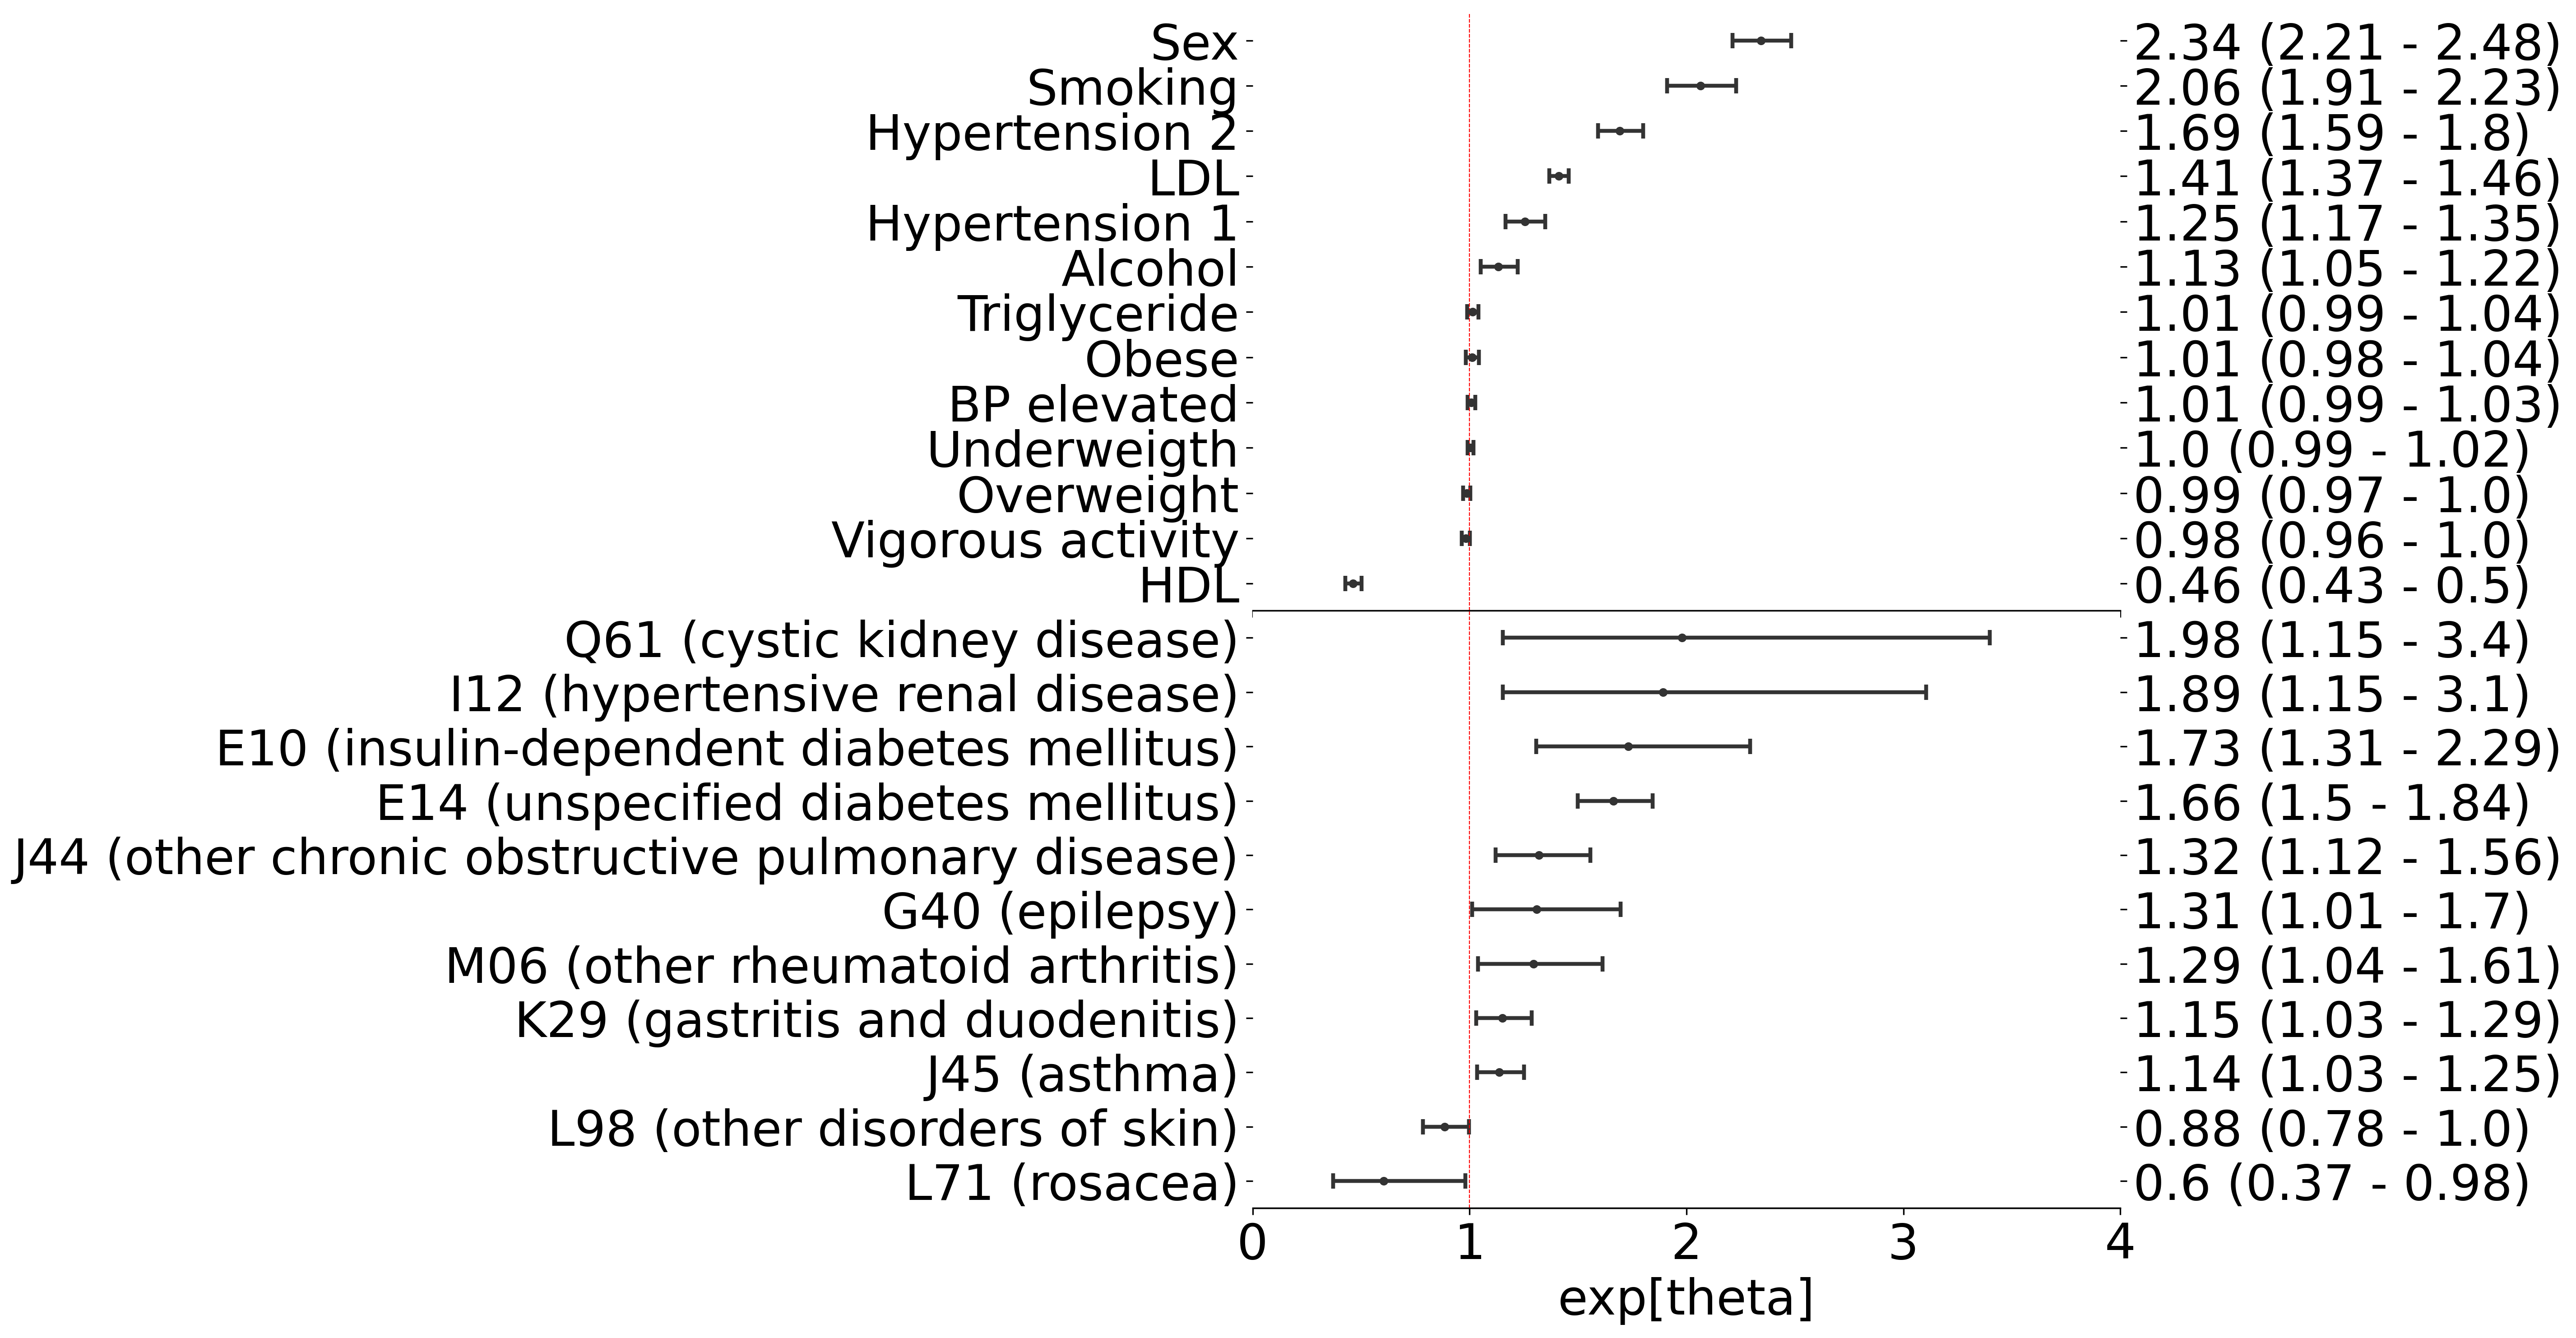

In [29]:
# Plot
# =======================================================================================================================


fig, ax = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=300, sharex=True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.0)

ax[0].errorbar(y=range(13), x=theta[:13][idx_base], xerr=(theta[:13, 0][idx_base] - theta_lower[:13, 0][idx_base], theta_upper[:13, 0][idx_base] - theta[:13, 0][idx_base]),  c='.2', ls='', marker='.', markersize='7', linewidth=2, capthick=2, capsize=4)
ax[0].axvline(1, linewidth=0.5, c='r', ls='--')
ax[0].set_yticks(range(13))
ax[0].set_yticklabels(baseline_names[idx_base])

ax0 = ax[0].twinx()
ax0.errorbar(y=range(13), x=theta[:13][idx_base], xerr=(theta[:13, 0][idx_base] - theta_lower[:13, 0][idx_base], theta_upper[:13, 0][idx_base] - theta[:13, 0][idx_base]),  c='.2', ls='', marker='.', markersize='7', linewidth=2, capthick=2, capsize=4)

ax0.axvline(1, linewidth=0.5, c='r', ls='--')
ax0.set_yticks(range(13))
ax0.set_yticklabels([str(np.round(theta[:13][idx_base][ii][0],2)) + ' (' +  str(np.round(theta_lower[:13][idx_base][ii][0],2)) + ' - ' +  str(np.round(theta_upper[:13][idx_base][ii][0],2)) + ')' for ii in range(13)])


theta_lower = theta_lower[13:][sign]
theta = theta[13:][sign]
theta_upper = theta_upper[13:][sign]
icd10_code_names = icd10_code_names[sign[:, 0]]
icd10_code_names[np.where(icd10_code_names == 'L98 (other disorders of skin and subcutaneous tissue, not elsewhere classified)')[0]] = 'L98 (other disorders of skin)'
idx_icd10 = np.argsort(theta)

ax[1].errorbar(y=range(np.sum(sign)), x=theta[idx_icd10], xerr=(theta[idx_icd10] - theta_lower[idx_icd10], theta_upper[idx_icd10] - theta[idx_icd10]),  c='.2', ls='', marker='.', markersize='7', linewidth=2, capthick=2, capsize=4)
ax[1].axvline(1, linewidth=0.5, c='r', ls='--')
ax[1].set_yticks(range(np.sum(sign)))
ax[1].set_yticklabels(icd10_code_names[idx_icd10])

ax1 = ax[1].twinx()
ax1.errorbar(y=range(np.sum(sign)), x=theta[idx_icd10], xerr=(theta[idx_icd10] - theta_lower[idx_icd10], theta_upper[idx_icd10] - theta[idx_icd10]),  c='.2', ls='', marker='.', markersize='7', linewidth=2, capthick=2, capsize=4)

ax1.axvline(1, linewidth=0.5, c='r', ls='--')
ax1.set_yticks(range(np.sum(sign)))
ax1.set_yticklabels([str(np.round(theta[idx_icd10][ii],2)) + ' (' +  str(np.round(theta_lower[idx_icd10][ii],2)) + ' - ' +  str(np.round(theta_upper[idx_icd10][ii],2)) + ')' for ii in range(len(idx_icd10))])
ax1.set_xlim([0, 4])
ax1.set_xlabel('exp[theta]')
ax[1].set_xlabel('exp[theta]')

plt.show()
plt.close()